# Laboratorium 4

### Konfiguracja

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [4]:
def gen_lines(num):
    xMax = 1000
    yMax = 1000
    for _ in range(num):
        new_added_lines.append( Line(Point(random.uniform(0, xMax), random.uniform(0, yMax))
                                  , Point(random.uniform(0, xMax), random.uniform(0, yMax))))
def get_all_lines():
    return LinesCollection([ line.as_list() for line in new_added_lines])

EPS = 10**(-13)

def orient(a, b, c):
    arr = np.array([ [a[0] - c[0], a[1] - c[1]], [b[0]-c[0], b[1]-c[1]] ])
    det = np.linalg.det(arr)
    #print("det", det)
    if det-EPS > 0: return 1
    elif det+EPS < 0: return -1
    else: return 0
    
def intersect(a1, a2, b1, b2) :
    o1 = orient( a1 , a2 , b1 )
    o2 = orient( a1 , a2 , b2 )
    o3 = orient( b1 , b2 , a1 )
    o4 = orient( b1 , b2 , a2 )
    if ( o1 != o2 ) and ( o3 != o4 ) :
        return True
    else:
        return False
    
"""
http://www.izdebski.edu.pl/kategorie/Informatyka/Cwiczenie_02.pdf
x_p = a1.x + t * dX_a1_a2
y_p = a1.y + t * dY_a1_a2

    dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2
t = -----------------------------------------
    dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2
    
"""
def dX(a, b): return b[0] - a[0]
def dY(a, b): return b[1] - a[1]
def intersect_point(a1, a2, b1, b2):
    dX_a1_a2 = dX(a1, a2)
    dY_a1_a2 = dY(a1, a2)
    
    dX_a1_b1 = dX(a1, b1)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_b1 = dY(a1, b1)
    dX_b1_b2 = dX(b1, b2)
    
    dX_a1_a2 = dX(a1, a2)
    dY_b1_b2 = dY(b1, b2)
    dY_a1_a2 = dY(a1, a2)
    dX_b1_b2 = dX(b1, b2)
    
    t = (dX_a1_b1 * dY_b1_b2 - dY_a1_b1 * dX_b1_b2) / (dX_a1_a2 * dY_b1_b2 - dY_a1_a2 * dX_b1_b2)
    
    return Point(a1[0] + t * dX_a1_a2, a1[1] + t * dY_a1_a2)

force_int = False
#new_added_lines = []
class Point:
    def __init__(self, x, y):
        if(force_int):
            self.x = int(x)
            self.y = int(y)
        else:      
            self.x = x
            self.y = y
    def __getitem__(self, index):
        if(index == 0): return self.x
        elif(index == 1): return self.y
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "p({},{})".format(self.x, self.y)
    def __len__(self):
        return 2
    def __eq__(self, other):
        return abs(self.x-other.x) < EPS and abs(self.y-other.y) < EPS
    
_line_ID = 0
class Line:
    
    def __init__(self, p1, p2, sortBy="x"):
        global _line_ID
        self.ID = _line_ID
        _line_ID += 1
        self.higher_node = None
        self.lower_node = None
        self.p1 = p1
        self.p2 = p2
           
                
    def intersect(self, other):
        if(not intersect(self.p1, self.p2, other.p1, other.p2)): return None
        else: return intersect_point(self.p1, self.p2, other.p1, other.p2)
        
    def is_above(self, other):
        o1 = orient(self.p1, self.p2, other.p1)
        o2 = orient(self.p1, self.p2, other.p2)
        if(o1+o2 >= 0 and o1*o2 >=0): return False
        return True
    
    def is_below(self, other):
        o1 = orient(self.p1, self.p2, other.p1)
        o2 = orient(self.p1, self.p2, other.p2)
        if(o1+o2 <= 0 and o1*o2 <=0): return False
        return True
    
    def __iter__(self):
        yield p1
        yield p2
    def __getitem__(self, index):
        if(index == 0): return self.p1
        elif(index == 1): return self.p2
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "l[{},{}]".format(self.p1, self.p2)
    def __eq__(self, other):
        return self.ID == other.ID
        
    def __len__(self):
        return 2
    def as_list(self):
        return [(self.p1.x, self.p1.y), (self.p2.x, self.p2.y)]
    def __array__(self):       ## TODO 
        return np.asarray([np.asarray([self.p1.x, self.p1.y]), np.asarray([self.p2.x, self.p2.y])])
        #return np.asarray([np.asarray([p1.x, p1.y]), np.asarray([p2.x, p2.y])])
        
class Figure:
    def __init__(self, lines=None, points=None, create=False):
        if(lines is not None):
            if(create):
                self.points = []
                for lines_as_list in lines:
                    point = Point(lines_as_list[0][0], lines_as_list[0][1])
                    self.points.append(point)
                point = Point(lines[-1][1][0], lines[-1][1][1])
                self.points.append(point)
            else:
                self.points = [line.p1 for line in lines]
                self.points.append(lines[-1].p2)

        elif(points is not None):
            if(create):
                self.points = []
                for point_as_list in points:
                    point = Point(point_as_list[0], point_as_list[1])
                    self.points.append(point)
            else:
                self.points = [point for point in points]
        self.lines = []
        for i,point in enumerate(self.points[:-1]):
            self.lines.append( Line(point, self.points[i+1]) )
        self.lines.append( Line(self.points[-1], self.points[0]) )
        
    def get_next(self, val):
        if(isinstance(val, int)):
            nast = val + 1
            if(nast >= len(self.points)): nast = 0
            return nast
        else:
            raise BaseException("Only int is supported")
    def get_prev(self, val):
        if(isinstance(val, int)):
            prev = val - 1
            if(prev < 0): prev = len(self.points) -1
            return prev
        else:
            raise BaseException("Only int is supported")
        
    def getLinesCollection(self):
        return LinesCollection(lines_as_list(self.lines))
    def getPointsCollection(self):
        return PointsCollection(points_as_list(self.points))
    
class Triangle(Figure):
    def __init__(self, lines=None, points=None, create=False):
        if((lines is not None and len(lines)!=2) or (points is not None and len(points)!=3)):
            raise BaseException("error")
        super(Triangle, self).__init__(lines=lines,points=points,create=create)
        
    def is_inside(self, other):
        a12 = orient ( self.points[0] , self.points[1] , self.points[2] )
        b12 = orient ( self.points[0] , self.points[1] , other )
        a23 = orient ( self.points[1] , self.points[2] , self.points[0] )
        b23 = orient ( self.points[1] , self.points[2] , other )
        a31 = orient ( self.points[2] , self.points[0] , self.points[1] )
        b31 = orient ( self.points[2] , self.points[0] , other )
        return ( a12 * b12 >= 0 ) and ( a23 * b23 >= 0 ) and ( a31 * b31 >= 0 )

            


def lines_as_list(lines):
    return [ line.as_list() for line in lines]
def points_as_list(points):
    return [ (p.x, p.y) for p in points]

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


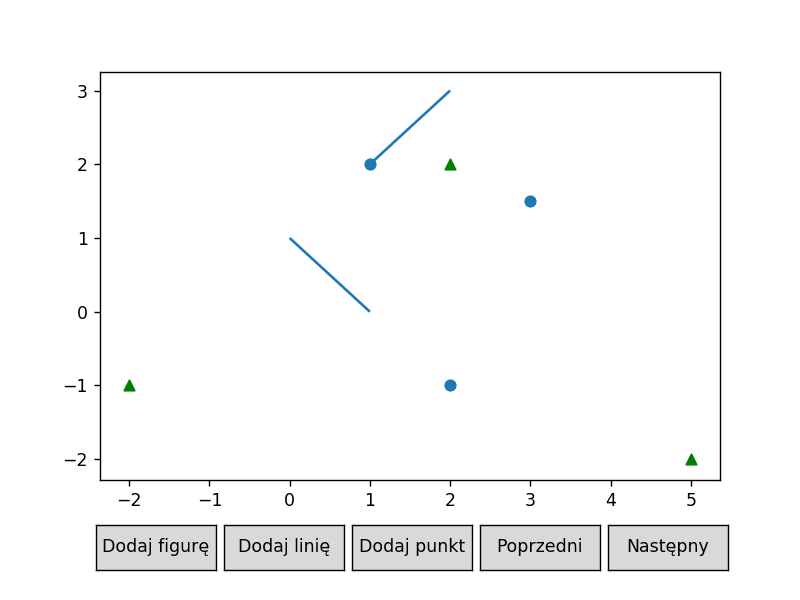

In [5]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


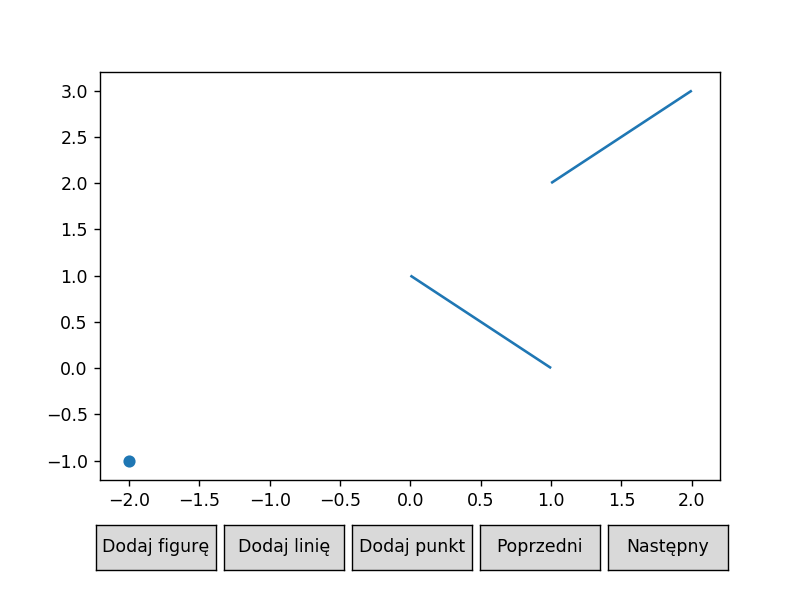

In [6]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


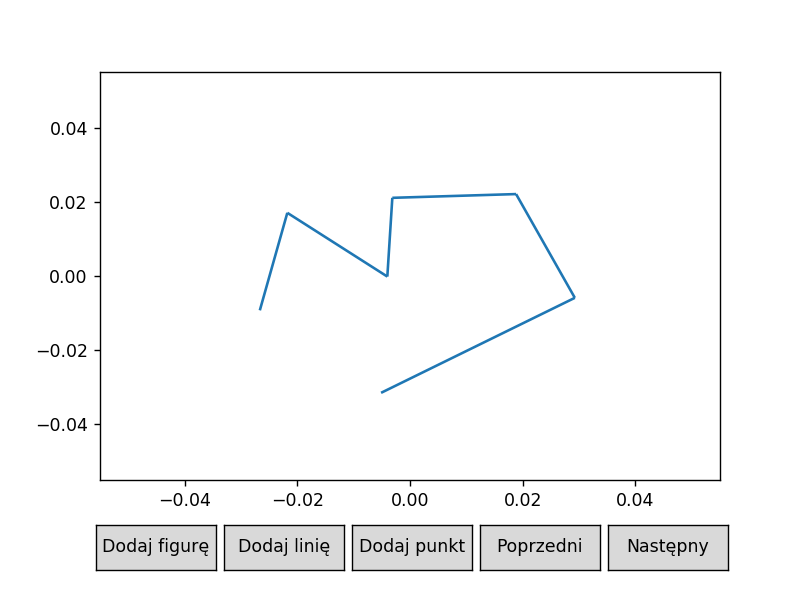

In [12]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


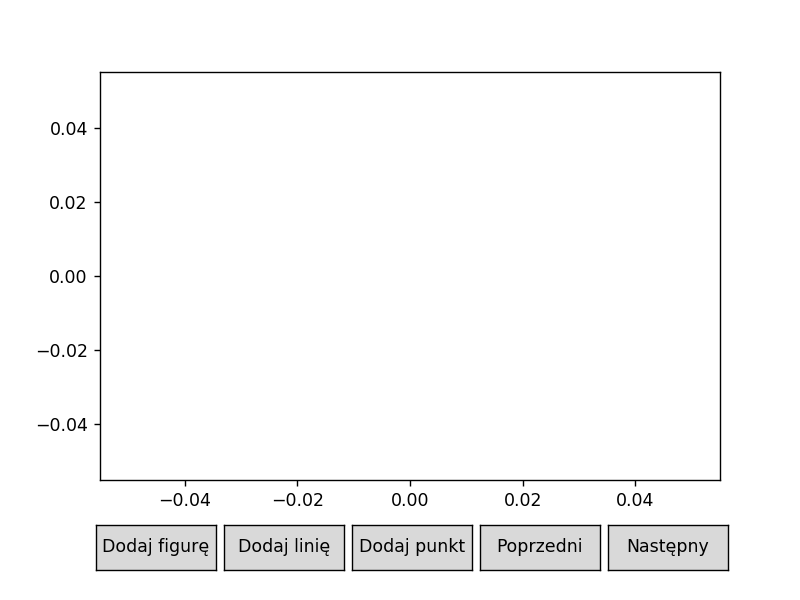

In [8]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [13]:
%matplotlib notebook
def Figure_from_Plot(plot):
    return Figure(lines=plot.get_added_elements().lines[0].lines, create=True)
fig = Figure_from_Plot(plot1)
fig.points

[p(-0.005131303110430321,-0.03149777777054732),
 p(0.02924369688956968,-0.005885032672508089),
 p(0.01882030979279549,0.02208678105298212),
 p(-0.003135335368494835,0.021075751641217402),
 p(-0.004022432142688395,-0.00015586600584142907),
 p(-0.02176436762655936,0.01703163399415858),
 p(-0.026643399884623872,-0.009255130711723777)]

<IPython.core.display.Javascript object>


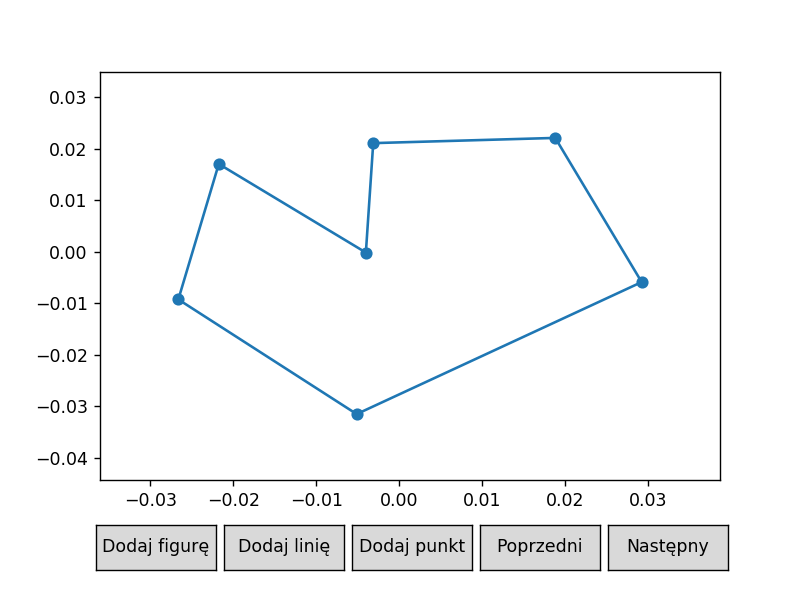

In [14]:
%matplotlib notebook

scenes=[Scene([fig.getPointsCollection()], [fig.getLinesCollection()])]
plot = Plot(scenes)
plot.draw() 

In [11]:
p1 = Point(1,2)
p2 = Point(2,4)
p3 = Point(3,1)
p4 = Point(2,0.5)
fig2 = Triangle(points=[p1,p2,p3], create=False)


<IPython.core.display.Javascript object>


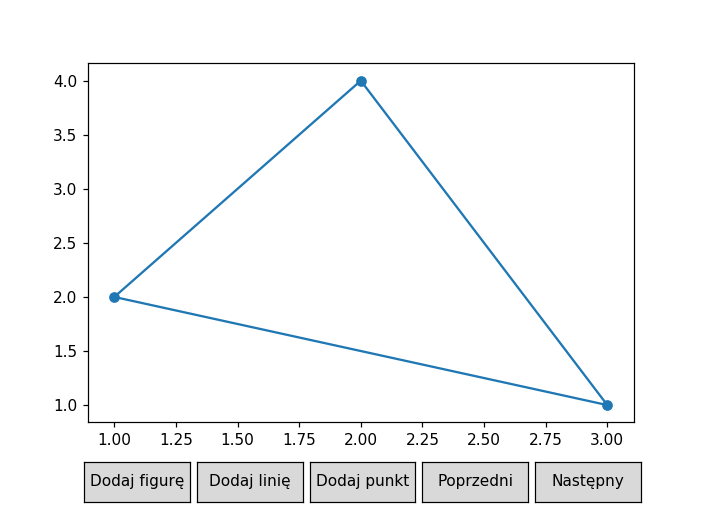

In [151]:
%matplotlib notebook

scenes=[Scene([fig2.getPointsCollection()], [fig2.getLinesCollection()])]

plot = Plot(scenes)
plot.draw() 

<IPython.core.display.Javascript object>


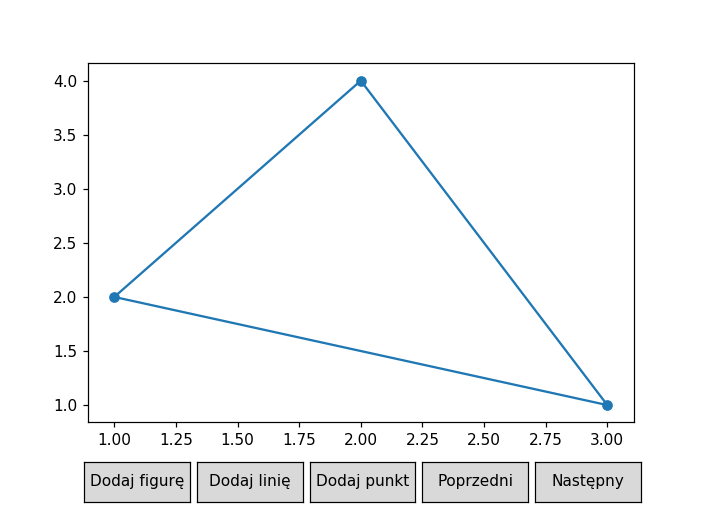

In [152]:
plot.draw() 

In [15]:
def is_y_monotonic(figure):
    top_point = figure.points[0]
    top_point_ind = 0
    bottom_point = figure.points[0]
    bottom_point_ind = 0
    for i, point in enumerate(figure.points):
        if top_point.y < point.y: 
            top_point = point
            top_point_ind = i
        if bottom_point.y > point.y: 
            bottom_point = point
            bottom_point_ind = i
    print(top_point, top_point_ind, bottom_point, bottom_point_ind)
    
    it = top_point_ind
    while(it != bottom_point_ind):
        nast_it = figure.get_next(it)
        ori = orient( (figure.points[it].x-1, figure.points[it].y), figure.points[it], figure.points[nast_it] )
        if(ori == 1): return False
        it = nast_it
    
    it = bottom_point_ind
    while(it != top_point_ind):
        nast_it = figure.get_next(it)
        #if(nast_it >= len(figure.points)): nast_it = 0
        ori = orient( (figure.points[it].x-1, figure.points[it].y), figure.points[it], figure.points[nast_it] )
        if(ori == -1): return False
        it = nast_it
    
    return True

"koncowy", "laczacy", "poczatkowy", "dzielacy", "prawidlowy"
def get_vertex_type(prev, curr, succ):
    if(prev.y > curr.y and succ.y > curr.y):
        # końcowy lub łączący
        ori = orient(prev, curr, succ)
        if(ori == 1):
            return "koncowy"
        elif(ori == -1):
            return "laczacy"
        else: raise BaseException("error")
    elif(prev.y < curr.y and succ.y < curr.y):
        # poczatkowy lub dzielacy
        ori = orient(prev, curr, succ)
        if(ori == 1):
            return "poczatkowy"
        elif(ori == -1):
            return "dzielacy"
        else: raise BaseException("error")
    return "prawidlowy"
            
#is_y_monotonic(fig)


p(0.01882030979279549,0.02208678105298212) 2 p(-0.005131303110430321,-0.03149777777054732) 0


False